# Analyse de sensibilités

In [16]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # pour les barres de progression

bd.projects.set_current('project_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0]
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]
fw_eutro = [ind for ind in meth if 'eutrophication' in str(ind).lower() and 'freshwater' in str(ind).lower()][0]

## Discrete Sensitivity Analysis (DSA)

La comparaison de nos deux bétons est en fait déjà une analyse de sensibilité discrète où nous avons étudié la sensibilité de notre modèle de béton armé au choix du ciment.

## One-at-a-time Local Sensitivity Analysis (OAT-LSA)

### Sensibilités aux valeurs d'échanges de premier-plan

On va réaliser une OAT-LSA sur chacun des échanges de premier-plan. Pour cela, on va parcourir les flux intermédiaires de notre procédé "Béton A", augmenter la valeur du flux d'une petite variation (1%) et faire le calcul ACV avec cette augmentation. Dans un second temps, on calcule les indicateurs de sensibilités vus en cours (sensibilité et élasticité) pour chacun des flux intermédiaires de premier-plan.

On calcule la valeur nominale du score d'impact ( $\tilde{y}$  dans le cours)

In [79]:
lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)
lca.lci()
lca.lcia()

y_tilde = lca.score # s stocke la valeur nominale (score du GWP)

On calcule ici le score ACV du béton A pour chaque échange qu'il a avec la technosphere augmenté de 1%, et on stocke les résultats dans des listes.

In [81]:
y_modif = []
xj_tilde = []
xj_modif = []
flux_j = []

lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)

for exc in beton_A.edges() :
    if exc['type'] != 'production' :
        lca.lci()
        lca.lcia()

        flux_j.append(bd.get_node(code = exc['input'][1])['name'])

        #On récupère les indices de colonnes et de lignes du béton et du procédé appelé par l'échange
        col_id = bd.Database(exc['output'][0]).get(exc['output'][1]).id
        row_id = bd.Database(exc['input'][0]).get(exc['input'][1]).id

        col = lca.dicts.activity[col_id]
        row = lca.dicts.activity[row_id]
        nominal_value = lca.technosphere_matrix[row,col] # On stocke la valeur du coefficient de la matrice A
        xj_tilde.append(np.abs(nominal_value)) # On stocke la valeur dans une liste
        var_value = nominal_value*1.01
        xj_modif.append(np.abs(var_value))
        lca.technosphere_matrix[row,col] =  var_value # On remplace le coefficient par une valeur 1% plus grande

        #on refait l'ACV avec la matrice modifiée
        lca.redo_lci()
        lca.lcia()
        y_modif.append(lca.score) # On ajoute le résultat à la liste

        #on restaure la matrice A
        lca.technosphere_matrix[row,col] = nominal_value


On range tout ça dans un tableau  :

In [82]:
df_OAT_LSA =pd.DataFrame(
    {
    'procédé_concerné' : flux_j,
    'xj_tilde' : xj_tilde,
    'xj_modif' : xj_modif,
    'y_tilde' : [y_tilde for _ in range(len(y_modif))],
    'y_modif' : y_modif
    })

In [83]:
df_OAT_LSA

,procédé_concerné,xj_tilde,xj_modif,y_tilde,y_modif
0,"market for cement, Portland",350.0,353.500,561.965028,565.050275
1,market for tap water,175.0,176.750,561.965028,561.965554
2,market for sand,800.0,808.000,561.965028,562.069415
3,"market for gravel, crushed",1100.0,1111.000,561.965028,562.167939
4,market for reinforcing steel,100.0,101.000,561.965028,564.177113
5,"diesel, burned in building machine",14.4,14.544,561.965028,561.979525


On ajoute des colonnes de résultats pour obtenir les $\Delta y$, $\Delta x_j$, la sensibilité $\delta_j$ et l'élasticité $ \varepsilon_j$ :

In [84]:
df_OAT_LSA['delta_y'] = df_OAT_LSA['y_modif'] - df_OAT_LSA['y_tilde']
df_OAT_LSA['delta_xj'] = df_OAT_LSA['xj_modif'] - df_OAT_LSA['xj_tilde']
df_OAT_LSA['sensibilite'] = df_OAT_LSA['delta_y']/df_OAT_LSA['delta_xj']
df_OAT_LSA['elasticite'] = df_OAT_LSA['sensibilite']*df_OAT_LSA['xj_tilde']/df_OAT_LSA['y_tilde']

In [85]:
df_OAT_LSA

,procédé_concerné,xj_tilde,xj_modif,y_tilde,y_modif,delta_y,delta_xj,sensibilite,elasticite
0,"market for cement, Portland",350.0,353.500,561.965028,565.050275,3.085247,3.500,0.881499,0.549010
1,market for tap water,175.0,176.750,561.965028,561.965554,0.000526,1.750,0.000300,0.000094
2,market for sand,800.0,808.000,561.965028,562.069415,0.104386,8.000,0.013048,0.018575
3,"market for gravel, crushed",1100.0,1111.000,561.965028,562.167939,0.202910,11.000,0.018446,0.036107
4,market for reinforcing steel,100.0,101.000,561.965028,564.177113,2.212085,1.000,2.212085,0.393634
5,"diesel, burned in building machine",14.4,14.544,561.965028,561.979525,0.014497,0.144,0.100673,0.002580


A quoi le modèle de béton produit est le plus sensible ?

### Sensibilités aux valeurs des flux élémentaires et intermédiaires

On fait ici exactement le même exercice que précédemment, mais en incluant les flux intermédaires et élémentaires de second-plan :

In [ ]:
echanges = []

for exc in beton_A.edges() :
    if e['type'] != 'production' :
        echanges.append(exc)
    a = bd.get_node(code = exc['input'][1])
    for e in a.edges() :
        if e['type'] != 'production' and e not in echanges :
            echanges.append(e)

production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
production
technosphere
technosphere
technosphere
technosphere
production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
biosphere
production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
production
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
technosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphere
biosphe

90

In [87]:
y_modif = []
xj_tilde = []
xj_modif = []
flux_j = []
noeuds = []

lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)

for exc in echanges :
    lca.lci()
    lca.lcia()

    flux_j.append(bd.get_node(code = exc['input'][1])['name'])
    noeuds.append(bd.get_node(code = exc['output'][1])['name'])

    #On récupère les indices de colonnes et de lignes du béton et du procédé appelé par l'échange
    col_id = bd.Database(exc['output'][0]).get(exc['output'][1]).id
    row_id = bd.Database(exc['input'][0]).get(exc['input'][1]).id

    if exc['type'] == "biosphere": # Si l'échange est avec la biosphère, on cherche le coefficient dans B
        col = lca.dicts.activity[col_id]
        row = lca.dicts.biosphere[row_id]
        nominal_value = lca.biosphere_matrix[row,col]
        xj_tilde.append(np.abs(nominal_value)) # On stocke la valeur dans une liste
        var_value = nominal_value*1.1
        xj_modif.append(np.abs(var_value))
        lca.biosphere_matrix[row,col] =  var_value # On remplace le coefficient par une valeur 1% plus grande
    else :
        col = lca.dicts.activity[col_id]
        row = lca.dicts.activity[row_id]
        nominal_value = lca.technosphere_matrix[row,col] # On stocke la valeur du coefficient de la matrice A
        xj_tilde.append(np.abs(nominal_value)) # On stocke la valeur dans une liste
        var_value = nominal_value*1.1
        xj_modif.append(np.abs(var_value))
        lca.technosphere_matrix[row,col] =  var_value # On remplace le coefficient par une valeur 1% plus grande

    #on refait l'ACV avec la matrice modifiée
    lca.redo_lci()
    lca.lcia()
    y_modif.append(lca.score) # On ajoute le résultat à la liste

    #on restaure les matrices A et B
    if exc['type'] == "biosphere":
        lca.biosphere_matrix[row,col] = nominal_value
    else : 
        lca.technosphere_matrix[row,col] = nominal_value



On regroupe les résultats dans un tableau pour les afficher, en ajoutant les colonnes qui nous intéressent :

In [88]:
df_OAT_LSA =pd.DataFrame(
    {
    'input' : flux_j,
    'output' : noeuds,
    'xj_tilde' : xj_tilde,
    'xj_modif' : xj_modif,
    'y_tilde' : [y_tilde for _ in range(len(y_modif))],
    'y_modif' : y_modif
    })

df_OAT_LSA['delta_y'] = df_OAT_LSA['y_modif'] - df_OAT_LSA['y_tilde']
df_OAT_LSA['delta_xj'] = df_OAT_LSA['xj_modif'] - df_OAT_LSA['xj_tilde']
df_OAT_LSA['sensibilite'] = df_OAT_LSA['delta_y']/df_OAT_LSA['delta_xj']
df_OAT_LSA['elasticite'] = df_OAT_LSA['sensibilite']*df_OAT_LSA['xj_tilde']/df_OAT_LSA['y_tilde']

On affiche le tableau en triant par elasticité décroissante :

In [89]:
pd.set_option('display.max_rows', 1000)
display(df_OAT_LSA.sort_values('elasticite',ascending = False))

,input,output,xj_tilde,xj_modif,y_tilde,y_modif,delta_y,delta_xj,sensibilite,elasticite
1,"market for cement, Portland",Béton A,3.500000e+02,3.850000e+02,561.965028,592.817495,30.852467,3.500000e+01,8.814991e-01,5.490104e-01
7,"market for cement, Portland",Béton A,3.500000e+02,3.850000e+02,561.965028,592.817495,30.852467,3.500000e+01,8.814991e-01,5.490104e-01
8,"cement production, Portland","market for cement, Portland",1.000000e+00,1.100000e+00,561.965028,592.002453,30.037425,1.000000e-01,3.003742e+02,5.345070e-01
54,market for reinforcing steel,Béton A,1.000000e+02,1.100000e+02,561.965028,584.085874,22.120846,1.000000e+01,2.212085e+00,3.936339e-01
5,market for reinforcing steel,Béton A,1.000000e+02,1.100000e+02,561.965028,584.085874,22.120846,1.000000e+01,2.212085e+00,3.936339e-01
55,reinforcing steel production,market for reinforcing steel,6.757512e-01,7.433263e-01,561.965028,577.091819,15.126791,6.757512e-02,2.238515e+02,2.691767e-01
56,reinforcing steel production,market for reinforcing steel,3.178523e-01,3.496375e-01,561.965028,568.855088,6.890059,3.178523e-02,2.167692e+02,1.226065e-01
4,"market for gravel, crushed",Béton A,1.100000e+03,1.210000e+03,561.965028,563.994131,2.029102,1.100000e+02,1.844639e-02,3.610727e-02
40,"market for gravel, crushed",Béton A,1.100000e+03,1.210000e+03,561.965028,563.994131,2.029102,1.100000e+02,1.844639e-02,3.610727e-02
41,"gravel production, crushed","market for gravel, crushed",1.000000e+00,1.100000e+00,561.965028,563.085210,1.120181,1.000000e-01,1.120181e+01,1.993329e-02


## One-at-a-time Global Sensitivity Analysis (OAT-GSA)

On définit des domaines aux paramètres pour lesquelles on veut connaître la sensiiblité globale du modèle. Ici, on va s'intéresser à trois variables :
- la quantité de ciment que l'on va faire varier entre 320 et 380kg/m3 ;
- la quantité de ferraillage que l'on va faire varier entre 50 et 200 kg/m3
- la quantité d'énergie de malaxage, que l'on va faire varier entre 5 et 30 MJ

In [ ]:
dom_cement = np.linspace(320,380,20)
dom_ferraillage = np.linspace(50,200,20)
dom_malax = np.linspace(5,30,20)

On parcourt ces domaines un à un en réalisant l'ACV pour chaque point :

In [140]:
domaine = []
scores = []
procede = []
xj_tilde = []

dict_domaines = {'cement' : dom_cement,'reinforcing steel' : dom_ferraillage, 'diesel' : dom_malax}

lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)

for k,v in dict_domaines.items() :
    lca.lci()
    lca.lcia()

    procede.append(k)
    domaine.append(v)
    exc = [e for e in beton_A.edges() if k in str(bd.get_node(code = e['input'][1])['name'])][0]

    #On récupère les indices de colonnes et de lignes du béton et du procédé appelé par l'échange
    col_id = bd.Database(exc['output'][0]).get(exc['output'][1]).id
    row_id = bd.Database(exc['input'][0]).get(exc['input'][1]).id

    col = lca.dicts.activity[col_id]
    row = lca.dicts.activity[row_id]
    nominal_value = lca.technosphere_matrix[row,col] # On stocke la valeur du coefficient de la matrice A
    xj_tilde.append(np.abs(nominal_value)) # On stocke la valeur dans une liste

    for x in v :
        lca.technosphere_matrix[row,col] =  -x 
        #on refait l'ACV avec la matrice modifiée
        lca.redo_lci()
        lca.lcia()
        scores.append(lca.score) # On ajoute le résultat à la liste

    #on restaure la matrice A
    lca.technosphere_matrix[row,col] = nominal_value

On range dans un tableau pour mieux tracer :



In [141]:
df_OAT_GSA = pd.DataFrame(
    {
    'procede' : ['cement']*len(dom_cement)+['reinforcing steel']*len(dom_ferraillage)+['diesel']*len(dom_malax),
    'x' : list(dom_cement)+list(dom_ferraillage)+list(dom_malax),
    'scores' : scores, 
    'xj_tilde' : xj_tilde[0]*len(dom_cement)+xj_tilde[1]*len(dom_ferraillage)+xj_tilde[2]*len(dom_malax),
    })


On trace, d'abord séparément :

Text(0.5, 1.0, "l'énergie de malaxage")

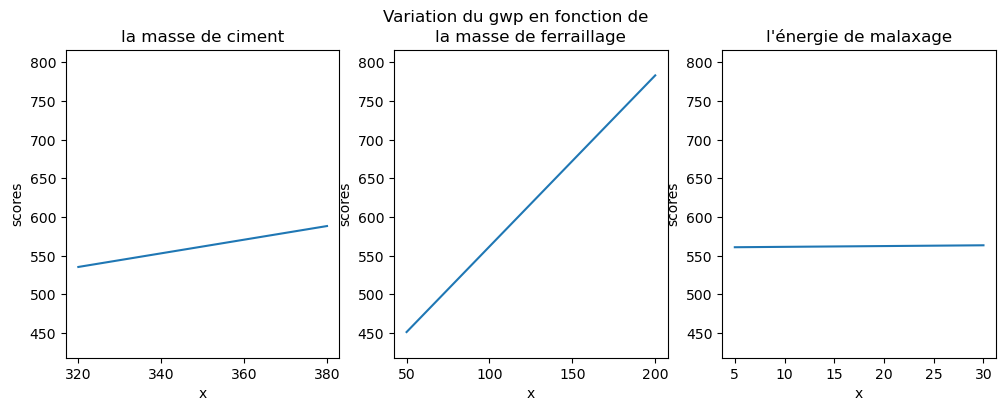

In [142]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data=df_OAT_GSA[df_OAT_GSA['procede']=='cement'], x = 'x', y='scores', ax = axs[0])
sns.lineplot(data=df_OAT_GSA[df_OAT_GSA['procede']=='reinforcing steel'], x = 'x', y='scores', ax = axs[1])
sns.lineplot(data=df_OAT_GSA[df_OAT_GSA['procede']=='diesel'], x = 'x', y='scores', ax = axs[2])

y_min, y_max = df_OAT_GSA['scores'].min(), df_OAT_GSA['scores'].max()
margin = 0.1 * (y_max - y_min)
y_min -= margin
y_max += margin

for ax in axs :
    ax.set_ylim(y_min, y_max) 
fig.suptitle('Variation du gwp en fonction de')
axs[0].set_title('la masse de ciment')
axs[1].set_title('la masse de ferraillage')
axs[2].set_title("l'énergie de malaxage")

Que dire ?

Pour tracer les trois sur le même graphe, on crée une colonne "x_relatif" où les quantités considérées sont divisées par la valeur nominale de l'échange.

In [143]:
x_relatif = []
dict_nominal = {'cement' : 350,'reinforcing steel' : 100, 'diesel' : 14.4}

for i in df_OAT_GSA.index :
    x_relatif.append(df_OAT_GSA.at[i,'x']/dict_nominal[df_OAT_GSA.at[i,'procede']])

df_OAT_GSA['x_relatif'] = x_relatif

Et on trace :

Text(0.5, 0.98, 'Variation du gwp en fonction des valeurs de flux relativement aux valeurs nominales')

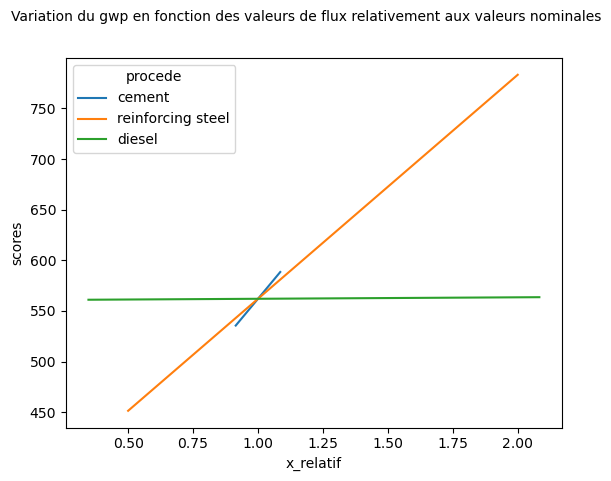

In [144]:
fig, ax = plt.subplots()

sns.lineplot(data=df_OAT_GSA, x = 'x_relatif', y='scores', hue = 'procede')
fig.suptitle("Variation du gwp en fonction des valeurs de flux relativement aux valeurs nominales", fontsize = 10)


Qu'apporte cette analyse par rapport à une analyse locale ?

## All-at-a-time Global Sensitivity Analysis (AAT-GSA)

Localement ou sur l'ensemble des domaines, nous avons modifié les valeurs de flux intermédiaires une par une. Ici, nous allons explorer les mêmes domaines que précédemment, mais en faisant varier les 3 variables en même temps. On note que l'on fait une Several-at-a-time GSA plutôt qu'une AAT-GSA.

Pour limiter les temps de calcul, on parcourt les domaines en faisant de grands pas :

In [154]:
dom_cement = np.linspace(320,380,5)
dom_ferraillage = np.linspace(50,200,5)
dom_malax = np.linspace(5,30,5)

On crée une liste de combinaisons de toutes les valeurs possibles

In [158]:
import itertools 
dom_total = itertools.product(dom_cement,dom_ferraillage,dom_malax)
dom_total = list(dom_total)

On réalise l'ACV du béton pour toutes les combinaisons de valeurs possibles :

In [ ]:
val_cement = []
val_steel = []
val_diesel = []
scores = []


lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)
lca.lci()
lca.lcia()

variables_names = ['cement','reinforcing steel','diesel']
dict_order = { 'cement' : 0,'reinforcing steel' : 1,'diesel' : 2}
dict_exc = {k :[e for e in beton_A.edges() if k in str(bd.get_node(code = e['input'][1])['name'])][0] for k in variables_names}
dict_col_id = {k : bd.Database(dict_exc[k]['output'][0]).get(dict_exc[k]['output'][1]).id for k in variables_names}
dict_row_id = {k : bd.Database(dict_exc[k]['input'][0]).get(dict_exc[k]['input'][1]).id for k in variables_names}
dict_col = {k : lca.dicts.activity[dict_col_id[k]] for k in variables_names}
dict_row = {k : lca.dicts.activity[dict_row_id[k]] for k in variables_names}

dict_nominal_value = {k : lca.technosphere_matrix[dict_row[k],dict_col[k]] for k in variables_names} # On stocke la valeur du coefficient de la matrice A

for t in dom_total :

    for k in variables_names :
        lca.technosphere_matrix[dict_row[k],dict_col[k]] = -t[dict_order[k]]
    
    #on refait l'ACV avec la matrice modifiée
    lca.redo_lci()
    lca.lcia()
    scores.append(lca.score) # On ajoute le résultat à la liste

#On restaure la matrice A au cas où

for k in variables_names :
    lca.technosphere_matrix[dict_row[k],dict_col[k]] = dict_nominal_value[k]

TypeError: 'set' object is not subscriptable

Comme d'habitude, on range dans un tableau pour mieux tracer :

In [165]:
df_AAT_GSA = pd.DataFrame(
    {
    'valeur_ciment' : [t[0] for t in dom_total],
    'valeur_ferraillage' : [t[1] for t in dom_total],
    'valeur_diesel' : [t[2] for t in dom_total],
    'scores' : scores,
    })

On trace :

Text(0.5, 1.0, "l'énergie de malaxage")

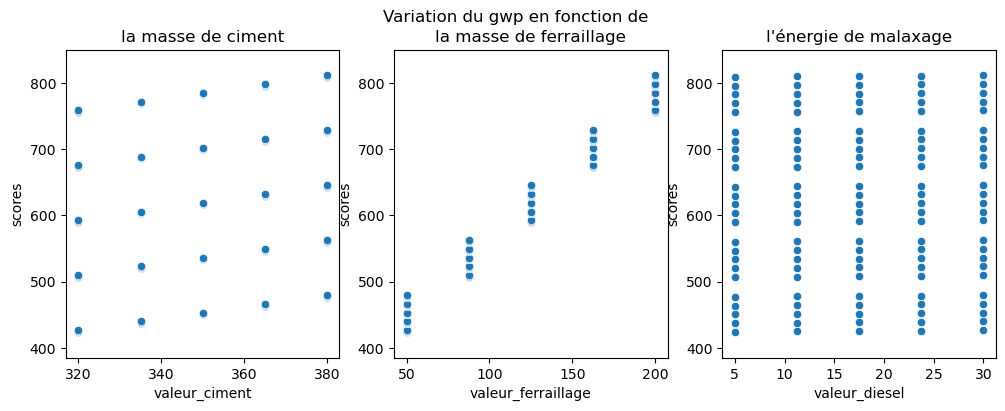

In [168]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

sns.scatterplot(data=df_OAT_GSA, x = 'valeur_ciment', y='scores', ax = axs[0])
sns.scatterplot(data=df_OAT_GSA, x = 'valeur_ferraillage', y='scores', ax = axs[1])
sns.scatterplot(data=df_OAT_GSA, x = 'valeur_diesel', y='scores', ax = axs[2])

y_min, y_max = df_AAT_GSA['scores'].min(), df_AAT_GSA['scores'].max()
margin = 0.1 * (y_max - y_min)
y_min -= margin
y_max += margin

for ax in axs :
    ax.set_ylim(y_min, y_max) 
fig.suptitle('Variation du gwp en fonction de')
axs[0].set_title('la masse de ciment')
axs[1].set_title('la masse de ferraillage')
axs[2].set_title("l'énergie de malaxage")

Que dire visuellement ?

On peut faire des statistiques rapides pour vérifier s'il y a des corrélations fortes et confirmer ce que l'on semble voir :

In [179]:
from scipy import stats

def calcul_correlations(y, x):
    pearson_r, pearson_p = stats.pearsonr(y, x)
    spearman_r, spearman_p = stats.spearmanr(y, x)

    return {
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p
    }

correlations = {x:calcul_correlations(df_OAT_GSA['scores'],df_OAT_GSA[x]) for x in ['valeur_ciment','valeur_ferraillage','valeur_diesel']}
df_correlations =pd.DataFrame(correlations).transpose()
df_correlations

,pearson_r,pearson_p,spearman_r,spearman_p
valeur_ciment,0.157405,7.958278e-02,0.195965,2.850744e-02
valeur_ferraillage,0.987506,1.429924e-100,0.979827,7.086650e-88
valeur_diesel,0.007490,9.339280e-01,0.039193,6.643199e-01


Avec quelle valeur de flux intermédiaire le score d'impact est-il fortement corrélé ?